In [ ]:
import numpy as np
from PIL import Image
import os
import string
import tensorflow as tf
from pickle import dump
from pickle import load
from keras.applications.xception import Xception #to get pre-trained model Xception
from keras.applications.xception import preprocess_input
from tensorflow.keras.utils import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from keras.preprocessing.text import Tokenizer #for text tokenization
from tensorflow.keras.utils import pad_sequences
from keras.utils import to_categorical
from keras.layers import Layer
from tensorflow.keras.layers import add
from keras.models import Model, load_model
from keras.layers import Input, Dense#Keras to build our CNN and LSTM
from keras.layers import LSTM, Embedding, Dropout
from tqdm.notebook import tqdm #to check loop progress
tqdm().pandas()

0it [00:00, ?it/s]

In [ ]:
!wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
!wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip

!unzip Flickr8k_Dataset.zip
!unzip Flickr8k_text.zip

In [ ]:
# Loading a text file into memory
def load_doc(filename):
    # Opening the file as read only
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

# get all imgs with their captions
def all_img_captions(filename):
    file = load_doc(filename)
    captions = file.split('\n')
    descriptions ={}
    for caption in captions[:-1]:
        img, caption = caption.split('\t')
        if img[:-2] not in descriptions:
            descriptions[img[:-2]] = [ caption ]
        else:
            descriptions[img[:-2]].append(caption)
    return descriptions

#Data cleaning- lower casing, removing puntuations and words containing numbers
def cleaning_text(captions):
    table = str.maketrans('','',string.punctuation)
    for img,caps in captions.items():
        for i,img_caption in enumerate(caps):

            img_caption.replace("-"," ")
            desc = img_caption.split()

            #converts to lowercase
            desc = [word.lower() for word in desc]
            #remove punctuation from each token
            desc = [word.translate(table) for word in desc]
            #remove hanging 's and a 
            desc = [word for word in desc if(len(word)>1)]
            #remove tokens with numbers in them
            desc = [word for word in desc if(word.isalpha())]
            #convert back to string

            img_caption = ' '.join(desc)
            captions[img][i]= img_caption
    return captions

def text_vocabulary(descriptions):
    # build vocabulary of all unique words
    vocab = set()

    for key in descriptions.keys():
        [vocab.update(d.split()) for d in descriptions[key]]

    return vocab

#All descriptions in one file 
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + '\t' + desc )
    data = "\n".join(lines)
    file = open(filename,"w")
    file.write(data)
    file.close()


# Set these path according to project folder in you system
dataset_text = ""
dataset_images = "Flicker8k_Dataset"

#we prepare our text data
filename = "Flickr8k.token.txt"
#loading the file that contains all data
#mapping them into descriptions dictionary img to 5 captions
descriptions = all_img_captions(filename)
print("Length of descriptions =" ,len(descriptions))

#cleaning the descriptions
clean_descriptions = cleaning_text(descriptions)

#building vocabulary 
vocabulary = text_vocabulary(clean_descriptions)
print("Length of vocabulary = ", len(vocabulary))

#saving each description to file 
save_descriptions(clean_descriptions, "descriptions.txt")

Length of descriptions = 8092
Length of vocabulary =  8763


In [ ]:
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

def extract_features(directory):
        model = Xception( include_top=False, pooling='avg' )
        features = {}
        for img in tqdm(os.listdir(directory)):
            filename = directory + "/" + img
            image = Image.open(filename)
            image = image.resize((299,299))
            image = np.expand_dims(image, axis=0)
            #image = preprocess_input(image)
            image = image/127.5
            image = image - 1.0

            feature = model.predict(image)
            features[img] = feature
        return features

#2048 feature vector
#features = extract_features(dataset_images)
#dump(features, open("features.p","wb"))

In [ ]:
features=load(open("features.p","rb"))

In [ ]:
#load the data 
def load_photos(filename):
    file = load_doc(filename)
    photos = file.split("\n")[:-1]
    return photos


def load_clean_descriptions(filename, photos): 
    #loading clean_descriptions
    file = load_doc(filename)
    descriptions = {}
    for line in file.split("\n"):

        words = line.split()
        if len(words)<1 :
            continue

        image, image_caption = words[0], words[1:]

        if image in photos:
            if image not in descriptions:
                descriptions[image] = []
            desc = '<start> ' + " ".join(image_caption) + ' <end>'
            descriptions[image].append(desc)

    return descriptions


def load_features(photos):
    #loading all features
    all_features = load(open("features.p","rb"))
    #selecting only needed features
    features = {k:all_features[k] for k in photos}
    return features


filename ="Flickr_8k.trainImages.txt"

#train = loading_data(filename)
train_imgs = load_photos(filename)
train_descriptions = load_clean_descriptions("descriptions.txt", train_imgs)
train_features = load_features(train_imgs)

In [ ]:
#converting dictionary to clean list of descriptions
def dict_to_list(descriptions):
    all_desc = []
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

#creating tokenizer class 
#this will vectorise text corpus
#each integer will represent token in dictionary

from keras.preprocessing.text import Tokenizer

def create_tokenizer(descriptions):
    desc_list = dict_to_list(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(desc_list)
    return tokenizer

# give each word an index, and store that into tokenizer.p pickle file
tokenizer = create_tokenizer(train_descriptions)
dump(tokenizer, open('tokenizer.p', 'wb'))
vocab_size = len(tokenizer.word_index) + 1
vocab_size

7577

In [ ]:
#calculate maximum length of descriptions
def max_length(descriptions):
    desc_list = dict_to_list(descriptions)
    return max(len(d.split()) for d in desc_list)
    
max_length = max_length(descriptions)
max_length

32

In [ ]:
#create input-output sequence pairs from the image description.

#data generator, used by model.fit_generator()
def data_generator(descriptions, features, tokenizer, max_length):
    while 1:
        for key, description_list in descriptions.items():
            #retrieve photo features
            feature = features[key][0]
            input_image, input_sequence, output_word = create_sequences(tokenizer, max_length, description_list, feature)
            yield [[input_image, input_sequence], output_word]

def create_sequences(tokenizer, max_length, desc_list, feature):
    X1, X2, y = list(), list(), list()
    # walk through each description for the image
    for desc in desc_list:
        # encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]
        # split one sequence into multiple X,y pairs
        for i in range(1, len(seq)):
            # split into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            # pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            # encode output sequence
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            # store
            X1.append(feature)
            X2.append(in_seq)
            y.append(out_seq)
    return np.array(X1), np.array(X2), np.array(y)

#You can check the shape of the input and output for your model
[a,b],c = next(data_generator(train_descriptions, features, tokenizer, max_length))
a.shape, b.shape, c.shape
#((47, 2048), (47, 32), (47, 7577))

((47, 2048), (47, 32), (47, 7577))

In [ ]:
from keras.layers import Layer
import tensorflow as tf
class BahdanauAttentionLayer(Layer):
    def __init__(self, units, **kwargs):
        super(BahdanauAttentionLayer, self).__init__(**kwargs)
        self.W1 = Dense(units)
        self.W2 = Dense(units)
        self.V = Dense(1)

    def call(self, inputs):
        # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)
        features, hidden = inputs
        # hidden shape == (batch_size, hidden_size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
        # attention_hidden_layer shape == (batch_size, 64, units)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        attention_hidden_layer = (tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis)))
        # score shape == (batch_size, 64, 1)
        # This gives you an unnormalized score for each image feature.
   
        score = self.V(attention_hidden_layer)
        attention_weights = tf.nn.softmax(score, axis=1)
        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2023-04-29 03:13:23--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-04-29 03:13:23--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-04-29 03:13:23--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
embeddings_index = dict()
f = open('glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [ ]:
embedding_matrix = np.zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    if index > vocab_size - 1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

In [ ]:
from keras.utils import plot_model
def define_model(vocab_size, max_length):
    # Features from the CNN model squeezed from 2048 to 256 nodes
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)

    # LSTM sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256, return_sequences=True, return_state=True)(se2)
    lstm_out, _, _ = se3

    # Attention layer
    attention_layer = BahdanauAttentionLayer(256)
    context_vector, _ = attention_layer([lstm_out, fe2])

    # Merging both models
    decoder1 = add([fe2, context_vector])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    # Tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    # Summarize model
    print(model.summary())
    plot_model(model, to_file='model.png', show_shapes=True)

    return model

In [ ]:
# train our model
print('Dataset: ', len(train_imgs))
print('Descriptions: train=', len(train_descriptions))
print('Photos: train=', len(train_features))
print('Vocabulary Size:', vocab_size)
print('Description Length: ', max_length)

model = define_model(vocab_size, max_length)
epochs = 10
steps = len(train_descriptions)
# making a directory models to save our models
#os.mkdir("models_atten_glove")
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, tokenizer, max_length)
    model.fit_generator(generator, epochs=1, steps_per_epoch= steps, verbose=1)
    model.save("models_atten_glove/model_" + str(i) + ".h5")

Dataset:  6000
Descriptions: train= 6000
Photos: train= 6000
Vocabulary Size: 7577
Description Length:  32
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 32)]         0           []                               
                                                                                                  
 input_9 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, 32, 256)      1939712     ['input_10[0][0]']               
                                                                                                  
 dropout_8 (Dropout)            (None, 2048)         0           ['input_9[0][0]']  

<ipython-input-25-b028f77c6102>:15: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator, epochs=1, steps_per_epoch= steps, verbose=1)


6000/6000 [==============================] - 628s 105ms/step - loss: 2.8541


In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import argparse


def extract_features(filename, model):
  try:
    image = Image.open(filename)
  except:
    print("ERROR: Couldn't open image! Make sure the image path and extension is correct")
  image = image.resize((299,299))
  image = np.array(image)
  # for images that has 4 channels, we convert them into 3 channels
  if image.shape[2] == 4: 
      image = image[..., :3]
  image = np.expand_dims(image, axis=0)
  image = image/127.5
  image = image - 1.0
  feature = model.predict(image)
  return feature

def word_for_id(integer, tokenizer):
  for word, index in tokenizer.word_index.items():
    if index == integer:
      return word
  return None


def generate_desc(model, tokenizer, photo, max_length):
  in_text = 'start'
  for i in range(max_length):
    sequence = tokenizer.texts_to_sequences([in_text])[0]
    sequence = pad_sequences([sequence], maxlen=max_length)
    pred = model.predict([photo,sequence], verbose=0)
    pred = np.argmax(pred)
    word = word_for_id(pred, tokenizer)
    if word is None:
        break
    in_text += ' ' + word
    if word == 'end':
        in_text += ' '
        break
  return in_text

In [ ]:
test_images = load_photos("Flickr_8k.testImages.txt")
# img_path = 'Flicker8k_Dataset/111537222_07e56d5a30.jpg'
xception_model = Xception(include_top=False, pooling="avg")

test_descriptions = {}
for img in test_images:
  img_path = "Flicker8k_Dataset/"+img
  max_length = 32

  photo = extract_features(img_path, xception_model)
  # img = Image.open(img_path)

  description = generate_desc(model, tokenizer, photo, max_length)
  test_descriptions[img] = description

In [ ]:
!pip install rouge-score
from keras.layers.pooling.average_pooling2d import AvgPool2D
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu

scorer = rouge_scorer.RougeScorer(['rougeL'])
ref_descriptions = load_clean_descriptions("descriptions.txt", test_images)

avg_rouge_scores = {"precision":[], "recall":[], "f1measure":[]}
avg_bleu_scores = []

for img in test_descriptions:
  desc_rouge_scores = {"precision":[], "recall":[], "f1measure":[]}
  # desc_bleu_scores = []
  avg_bleu_score = sentence_bleu([i.split() for i in ref_descriptions[img]], test_descriptions[img].split())
  for desc in ref_descriptions[img]:
    rouge_score = scorer.score(test_descriptions[img], desc)
    desc_rouge_scores["precision"].append(rouge_score["rougeL"][0])
    desc_rouge_scores["recall"].append(rouge_score["rougeL"][1])
    desc_rouge_scores["f1measure"].append(rouge_score["rougeL"][2])
    # desc_bleu_scores.append(bleu_score)  
  
  # avg_bleu_score = sum(desc_bleu_scores)/len(desc_bleu_scores)
  avg_rouge_precision = sum(desc_rouge_scores["precision"])/len(desc_rouge_scores["precision"])
  avg_rouge_recall = sum(desc_rouge_scores["recall"])/len(desc_rouge_scores["recall"])
  avg_rouge_f1measure = sum(desc_rouge_scores["f1measure"])/len(desc_rouge_scores["f1measure"])

  avg_bleu_scores.append(avg_bleu_score)
  avg_rouge_scores["precision"].append(avg_rouge_precision)
  avg_rouge_scores["recall"].append(avg_rouge_recall)  
  avg_rouge_scores["f1measure"].append(avg_rouge_f1measure)    

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24954 sha256=063c8e5e8eab9b4ad9a42069b894eff73c8f88fdac206c0a7e3027a835997ae7
  Stored in directory: /root/.cache/pip/wheels/9b/3d/39/09558097d3119ca0a4d462df68f22c6f3c1b345ac63a09b86e
Successfully built rouge-score


/usr/local/lib/python3.9/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.9/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.9/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg

In [ ]:
import json
with open("models_atten_glove/predictions.json","w") as f:
  json.dump(test_descriptions, f)

In [ ]:
print("BLEU score: ", sum(avg_bleu_scores)/len(avg_bleu_scores))
print("ROUGE precision: ", sum(avg_rouge_scores["precision"])/len(avg_rouge_scores["precision"]))
print("ROUGE recall: ", sum(avg_rouge_scores["recall"])/len(avg_rouge_scores["recall"]))
print("ROUGE f1: ", sum(avg_rouge_scores["f1measure"])/len(avg_rouge_scores["f1measure"]))

BLEU score:  0.017126929299152036
ROUGE precision:  0.3402192971933726
ROUGE recall:  0.3568110940976804
ROUGE f1:  0.3389672699989003


1/1 [==============================] - 1s 715ms/step



start brown dog is running through the grass end 


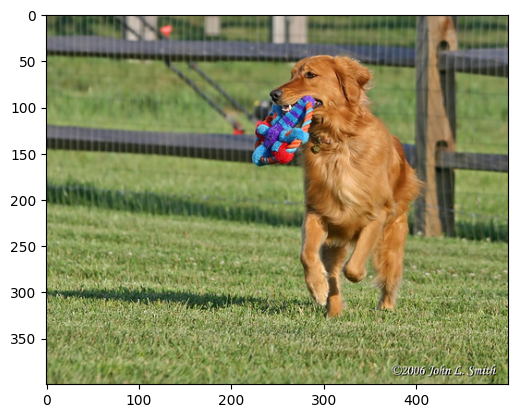

In [ ]:
img_path = 'Flicker8k_Dataset/316833109_6500b526dc.jpg'
max_length = 32
tokenizer = load(open("tokenizer.p","rb"))
# model = load_model('models_atten_glove/model_9.h5',custom_objects={'BahdanauAttention': BahdanauAttentionLayer})
xception_model = Xception(include_top=False, pooling="avg")
photo = extract_features(img_path, xception_model)
img = Image.open(img_path)

description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)

1/1 [==============================] - 1s 1s/step



start two people are walking along the water end 


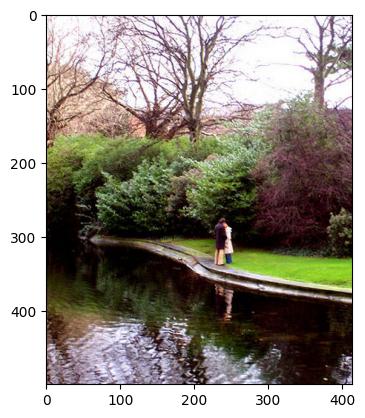

In [ ]:
img_path = 'Flicker8k_Dataset/3637013_c675de7705.jpg'
max_length = 32
tokenizer = load(open("tokenizer.p","rb"))
# model = load_model('models_atten_glove/model_9.h5',custom_objects={'BahdanauAttention': BahdanauAttention})
xception_model = Xception(include_top=False, pooling="avg")

photo = extract_features(img_path, xception_model)
img = Image.open(img_path)

description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)

1/1 [==============================] - 1s 703ms/step



start two dogs are playing in the grass end 


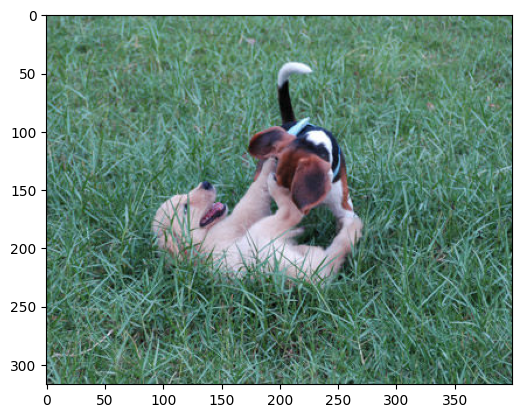

In [ ]:
img_path = 'Flicker8k_Dataset/23445819_3a458716c1.jpg'
max_length = 32
tokenizer = load(open("tokenizer.p","rb"))
# model = load_model('models_atten_glove/model_9.h5',custom_objects={'BahdanauAttention': BahdanauAttention})
xception_model = Xception(include_top=False, pooling="avg")

photo = extract_features(img_path, xception_model)
img = Image.open(img_path)

description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)

1/1 [==============================] - 1s 702ms/step



start man is riding on railing at the top of stairs end 


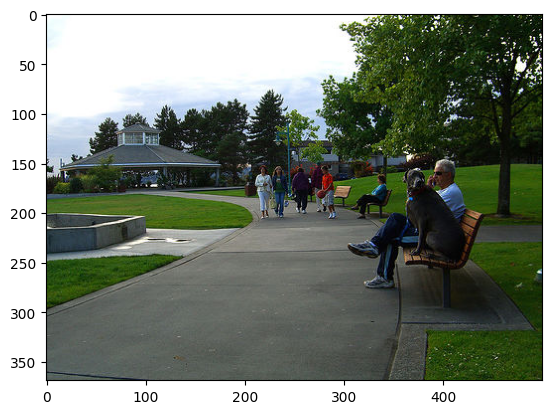

In [ ]:
img_path = 'Flicker8k_Dataset/42637987_866635edf6.jpg'
max_length = 32
tokenizer = load(open("tokenizer.p","rb"))
# model = load_model('models_atten_glove/model_9.h5',custom_objects={'BahdanauAttention': BahdanauAttention})
xception_model = Xception(include_top=False, pooling="avg")

photo = extract_features(img_path, xception_model)
img = Image.open(img_path)

description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)

1/1 [==============================] - 1s 753ms/step



start man in red shirt is walking on snowy mountain end 


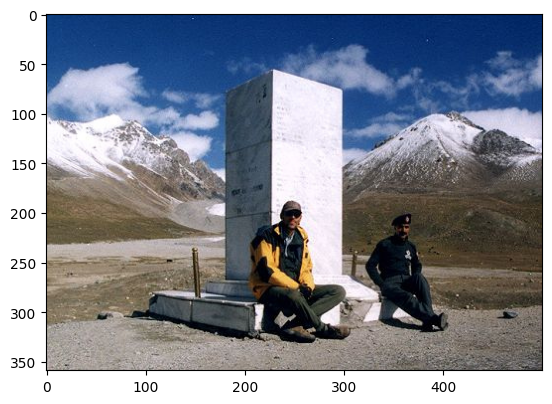

In [ ]:
img_path = 'Flicker8k_Dataset/95728664_06c43b90f1.jpg'
max_length = 32
tokenizer = load(open("tokenizer.p","rb"))
# model = load_model('models_atten_glove/model_9.h5',custom_objects={'BahdanauAttention': BahdanauAttention})
xception_model = Xception(include_top=False, pooling="avg")

photo = extract_features(img_path, xception_model)
img = Image.open(img_path)

description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)

1/1 [==============================] - 1s 755ms/step



start the dog is running along the beach end 


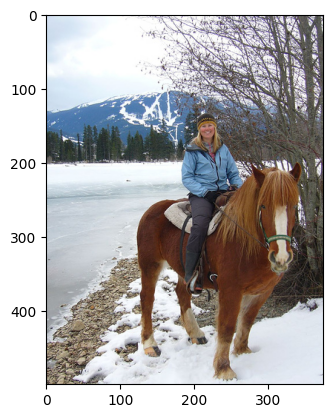

In [ ]:
img_path = 'Flicker8k_Dataset/109202756_b97fcdc62c.jpg'
max_length = 32
tokenizer = load(open("tokenizer.p","rb"))
# model = load_model('models_atten_glove/model_9.h5',custom_objects={'BahdanauAttention': BahdanauAttention})
xception_model = Xception(include_top=False, pooling="avg")

photo = extract_features(img_path, xception_model)
img = Image.open(img_path)

description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)

1/1 [==============================] - 1s 1s/step



start man is climbing up rock end 


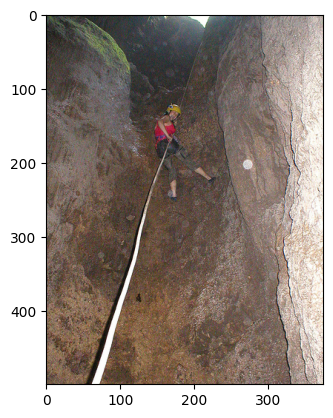

In [ ]:
img_path = 'Flicker8k_Dataset/109260216_85b0be5378.jpg'
max_length = 32
tokenizer = load(open("tokenizer.p","rb"))
# model = load_model('models_atten_glove/model_9.h5',custom_objects={'BahdanauAttention': BahdanauAttention})
xception_model = Xception(include_top=False, pooling="avg")

photo = extract_features(img_path, xception_model)
img = Image.open(img_path)

description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)

1/1 [==============================] - 1s 578ms/step



start baseball player in red shirt is running with ball end 


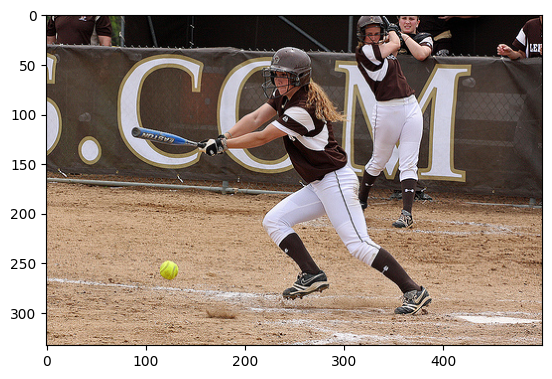

In [ ]:
img_path = 'Flicker8k_Dataset/3517124784_4b4eb62a7a.jpg'
max_length = 32
tokenizer = load(open("tokenizer.p","rb"))
model = load_model('models_atten_glove/model_9.h5',custom_objects={'BahdanauAttention': BahdanauAttention})
xception_model = Xception(include_top=False, pooling="avg")

photo = extract_features(img_path, xception_model)
img = Image.open(img_path)

description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)

1/1 [==============================] - 1s 582ms/step



start dog is running through the grass end 


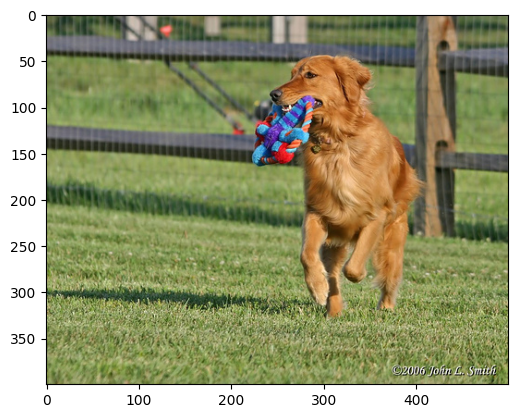

In [ ]:
img_path = 'Flicker8k_Dataset/316833109_6500b526dc.jpg'
max_length = 32
tokenizer = load(open("tokenizer.p","rb"))
model = load_model('models_atten_glove/model_9.h5',custom_objects={'BahdanauAttention': BahdanauAttention})
xception_model = Xception(include_top=False, pooling="avg")

photo = extract_features(img_path, xception_model)
img = Image.open(img_path)

description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)

# Without attention (glove embeddings)

In [ ]:
from keras.utils import plot_model
# define the captioning model
def define_model(vocab_size, max_length):
  # features from the CNN model squeezed from 2048 to 256 nodes
  inputs1 = Input(shape=(2048,))
  fe1 = Dropout(0.5)(inputs1)
  fe2 = Dense(256, activation='relu')(fe1)
  # LSTM sequence model
  inputs2 = Input(shape=(max_length,))
  se1 = Embedding(vocab_size, 100, mask_zero=True,weights=[embedding_matrix], trainable=False, input_length=max_length)(inputs2)
  # se2 = Dropout(0.5)(se1)
  se3 = LSTM(256)(se1)
  # Merging both models
  decoder1 = add([fe2, se3])
  decoder2 = Dense(256, activation='relu')(decoder1)
  outputs = Dense(vocab_size, activation='softmax')(decoder2)
  # tie it together [image, seq] [word]
  model = Model(inputs=[inputs1, inputs2], outputs=outputs)
  model.compile(loss='categorical_crossentropy', optimizer='adam')
  # summarize model
  print(model.summary())
  plot_model(model, to_file='model_glove_only.png', show_shapes=True)
  return model

In [ ]:
# model = define_model(vocab_size, max_length)
model = load_model('model_glove_6.h5')

epochs = 3
steps = len(train_descriptions)

# epochs = 10
steps = len(train_descriptions)
# making a directory models to save our models
os.mkdir("models")
for i in range(epochs):
  generator = data_generator(train_descriptions, train_features, tokenizer, max_length)
  model.fit(generator, epochs=1, steps_per_epoch= steps, verbose=1)
  model.save("models/model_glove_" + str(i+7) + ".h5")

6000/6000 [==============================] - 1458s 243ms/step - loss: 2.3341


In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import argparse


def extract_features(filename, model):
  try:
    image = Image.open(filename)
  except:
    print("ERROR: Couldn't open image! Make sure the image path and extension is correct")
  image = image.resize((299,299))
  image = np.array(image)
  # for images that has 4 channels, we convert them into 3 channels
  if image.shape[2] == 4: 
      image = image[..., :3]
  image = np.expand_dims(image, axis=0)
  image = image/127.5
  image = image - 1.0
  feature = model.predict(image)
  return feature

def word_for_id(integer, tokenizer):
  for word, index in tokenizer.word_index.items():
    if index == integer:
      return word
  return None


def generate_desc(model, tokenizer, photo, max_length):
  in_text = 'start'
  for i in range(max_length):
    sequence = tokenizer.texts_to_sequences([in_text])[0]
    sequence = pad_sequences([sequence], maxlen=max_length)
    pred = model.predict([photo,sequence], verbose=0)
    pred = np.argmax(pred)
    word = word_for_id(pred, tokenizer)
    if word is None:
        break
    in_text += ' ' + word
    if word == 'end':
        in_text += ' '
        break
  return in_text

In [ ]:
test_images = load_photos("Flickr_8k.testImages.txt")
# img_path = 'Flicker8k_Dataset/111537222_07e56d5a30.jpg'
xception_model = Xception(include_top=False, pooling="avg")

test_descriptions = {}
for img in test_images:
  img_path = "Flicker8k_Dataset/"+img
  max_length = 32

  photo = extract_features(img_path, xception_model)
  # img = Image.open(img_path)

  description = generate_desc(model, tokenizer, photo, max_length)
  test_descriptions[img] = description

In [ ]:
!pip install rouge-score
from keras.layers.pooling.average_pooling2d import AvgPool2D
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu

scorer = rouge_scorer.RougeScorer(['rougeL'])
ref_descriptions = load_clean_descriptions("descriptions.txt", test_images)

avg_rouge_scores = {"precision":[], "recall":[], "f1measure":[]}
avg_bleu_scores = []

for img in test_descriptions:
  desc_rouge_scores = {"precision":[], "recall":[], "f1measure":[]}
  # desc_bleu_scores = []
  avg_bleu_score = sentence_bleu([i.split() for i in ref_descriptions[img]], test_descriptions[img].split())
  for desc in ref_descriptions[img]:
    rouge_score = scorer.score(test_descriptions[img], desc)
    desc_rouge_scores["precision"].append(rouge_score["rougeL"][0])
    desc_rouge_scores["recall"].append(rouge_score["rougeL"][1])
    desc_rouge_scores["f1measure"].append(rouge_score["rougeL"][2])
    # desc_bleu_scores.append(bleu_score)  
  
  # avg_bleu_score = sum(desc_bleu_scores)/len(desc_bleu_scores)
  avg_rouge_precision = sum(desc_rouge_scores["precision"])/len(desc_rouge_scores["precision"])
  avg_rouge_recall = sum(desc_rouge_scores["recall"])/len(desc_rouge_scores["recall"])
  avg_rouge_f1measure = sum(desc_rouge_scores["f1measure"])/len(desc_rouge_scores["f1measure"])

  avg_bleu_scores.append(avg_bleu_score)
  avg_rouge_scores["precision"].append(avg_rouge_precision)
  avg_rouge_scores["recall"].append(avg_rouge_recall)  
  avg_rouge_scores["f1measure"].append(avg_rouge_f1measure)    

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24954 sha256=b3864def79b74cead5e7da33cb3f354539535dcac4ca1db050bb8d3233a8c6c7
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

In [ ]:
os.mkdir("glove_only")
import json
with open("glove_only/predictions.json","w") as f:
  json.dump(test_descriptions, f)

In [ ]:
print("BLEU score: ", sum(avg_bleu_scores)/len(avg_bleu_scores))
print("ROUGE precision: ", sum(avg_rouge_scores["precision"])/len(avg_rouge_scores["precision"]))
print("ROUGE recall: ", sum(avg_rouge_scores["recall"])/len(avg_rouge_scores["recall"]))
print("ROUGE f1: ", sum(avg_rouge_scores["f1measure"])/len(avg_rouge_scores["f1measure"]))

BLEU score:  0.010717307285247184
ROUGE precision:  0.3399107383416162
ROUGE recall:  0.33526428104369743
ROUGE f1:  0.32627970130429484


1/1 [==============================] - 1s 696ms/step



start brown dog is running through grassy field end 


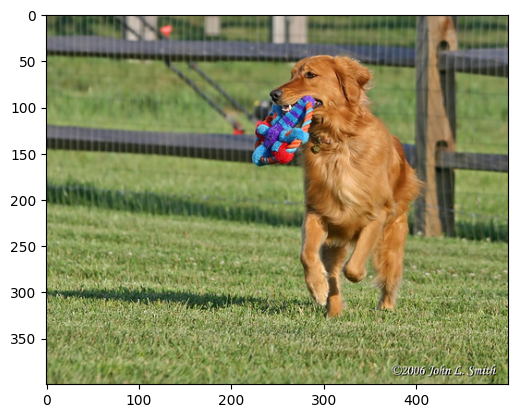

In [ ]:
img_path = 'Flicker8k_Dataset/316833109_6500b526dc.jpg'
max_length = 32
tokenizer = load(open("tokenizer.p","rb"))
# model = load_model('models_atten_glove/model_9.h5',custom_objects={'BahdanauAttention': BahdanauAttentionLayer})
xception_model = Xception(include_top=False, pooling="avg")
photo = extract_features(img_path, xception_model)
img = Image.open(img_path)

description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)

1/1 [==============================] - 1s 1s/step



start man is standing on rock overlooking the water end 


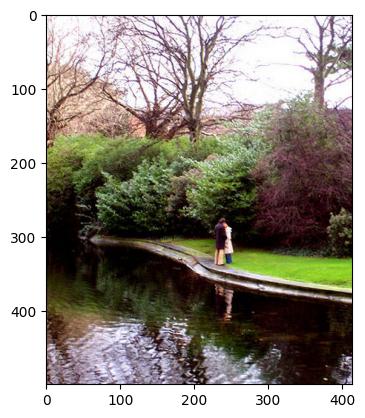

In [ ]:
img_path = 'Flicker8k_Dataset/3637013_c675de7705.jpg'
max_length = 32
tokenizer = load(open("tokenizer.p","rb"))
# model = load_model('models_atten_glove/model_9.h5',custom_objects={'BahdanauAttention': BahdanauAttention})
xception_model = Xception(include_top=False, pooling="avg")

photo = extract_features(img_path, xception_model)
img = Image.open(img_path)

description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)

1/1 [==============================] - 1s 729ms/step



start two dogs are playing tug of war end 


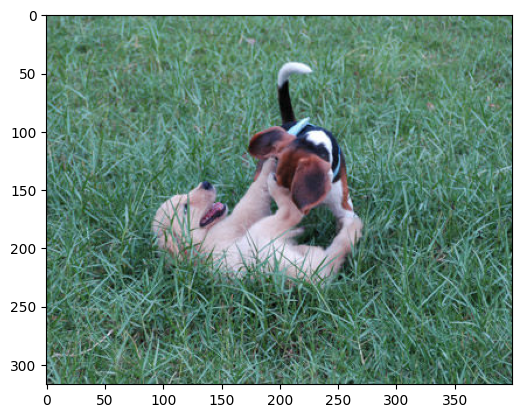

In [ ]:
img_path = 'Flicker8k_Dataset/23445819_3a458716c1.jpg'
max_length = 32
tokenizer = load(open("tokenizer.p","rb"))
# model = load_model('models_atten_glove/model_9.h5',custom_objects={'BahdanauAttention': BahdanauAttention})
xception_model = Xception(include_top=False, pooling="avg")

photo = extract_features(img_path, xception_model)
img = Image.open(img_path)

description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)

1/1 [==============================] - 1s 719ms/step



start man in blue shirt is standing in front of some cars end 


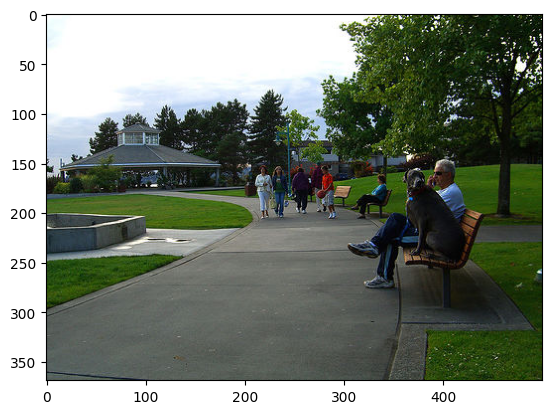

In [ ]:
img_path = 'Flicker8k_Dataset/42637987_866635edf6.jpg'
max_length = 32
tokenizer = load(open("tokenizer.p","rb"))
# model = load_model('models_atten_glove/model_9.h5',custom_objects={'BahdanauAttention': BahdanauAttention})
xception_model = Xception(include_top=False, pooling="avg")

photo = extract_features(img_path, xception_model)
img = Image.open(img_path)

description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)

1/1 [==============================] - 1s 690ms/step



start man is sitting on top of mountain end 


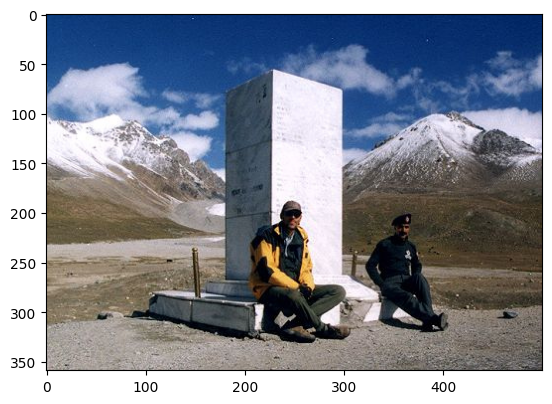

In [ ]:
img_path = 'Flicker8k_Dataset/95728664_06c43b90f1.jpg'
max_length = 32
tokenizer = load(open("tokenizer.p","rb"))
# model = load_model('models_atten_glove/model_9.h5',custom_objects={'BahdanauAttention': BahdanauAttention})
xception_model = Xception(include_top=False, pooling="avg")

photo = extract_features(img_path, xception_model)
img = Image.open(img_path)

description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)

1/1 [==============================] - 1s 807ms/step



start black and white dog is running through the snow end 


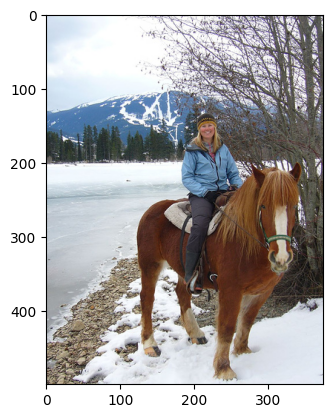

In [ ]:
img_path = 'Flicker8k_Dataset/109202756_b97fcdc62c.jpg'
max_length = 32
tokenizer = load(open("tokenizer.p","rb"))
# model = load_model('models_atten_glove/model_9.h5',custom_objects={'BahdanauAttention': BahdanauAttention})
xception_model = Xception(include_top=False, pooling="avg")

photo = extract_features(img_path, xception_model)
img = Image.open(img_path)

description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)

1/1 [==============================] - 1s 702ms/step



start man climbing large rock end 


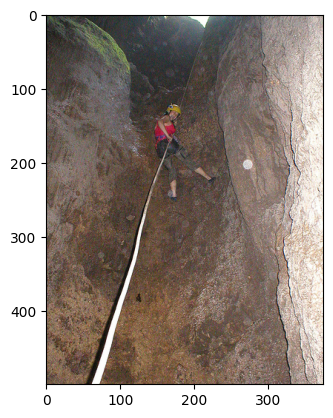

In [ ]:
img_path = 'Flicker8k_Dataset/109260216_85b0be5378.jpg'
max_length = 32
tokenizer = load(open("tokenizer.p","rb"))
# model = load_model('models_atten_glove/model_9.h5',custom_objects={'BahdanauAttention': BahdanauAttention})
xception_model = Xception(include_top=False, pooling="avg")

photo = extract_features(img_path, xception_model)
img = Image.open(img_path)

description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)

1/1 [==============================] - 3s 3s/step



start two boys playing soccer on field end 


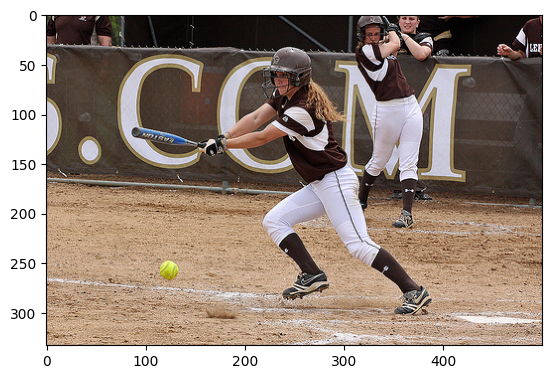

In [ ]:
img_path = 'Flicker8k_Dataset/3517124784_4b4eb62a7a.jpg'
max_length = 32
tokenizer = load(open("tokenizer.p","rb"))
# model = load_model('models_atten_glove/model_9.h5',custom_objects={'BahdanauAttention': BahdanauAttention})
xception_model = Xception(include_top=False, pooling="avg")

photo = extract_features(img_path, xception_model)
img = Image.open(img_path)

description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)

# Attention + glove

In [ ]:
from keras.layers import Layer
import tensorflow as tf
class BahdanauAttentionLayer(Layer):
    def __init__(self, units, **kwargs):
        super(BahdanauAttentionLayer, self).__init__(**kwargs)
        self.W1 = Dense(units)
        self.W2 = Dense(units)
        self.V = Dense(1)

    def call(self, inputs):
        # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)
        features, hidden = inputs
        # hidden shape == (batch_size, hidden_size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
        # attention_hidden_layer shape == (batch_size, 64, units)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        attention_hidden_layer = (tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis)))
        # score shape == (batch_size, 64, 1)
        # This gives you an unnormalized score for each image feature.
   
        score = self.V(attention_hidden_layer)
        attention_weights = tf.nn.softmax(score, axis=1)
        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

In [ ]:
from keras.utils import plot_model
def define_model(vocab_size, max_length):
    # Features from the CNN model squeezed from 2048 to 256 nodes
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)

    # LSTM sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 100, mask_zero=True,weights=[embedding_matrix], trainable=False, input_length=max_length)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256, return_sequences=True, return_state=True)(se2)
    lstm_out, _, _ = se3

    # Attention layer
    attention_layer = BahdanauAttentionLayer(256)
    context_vector, _ = attention_layer([lstm_out, fe2])

    # Merging both models
    decoder1 = add([fe2, context_vector])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    # Tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    # Summarize model
    print(model.summary())
    plot_model(model, to_file='model.png', show_shapes=True)

    return model

In [ ]:
# train our model
print('Dataset: ', len(train_imgs))
print('Descriptions: train=', len(train_descriptions))
print('Photos: train=', len(train_features))
print('Vocabulary Size:', vocab_size)
print('Description Length: ', max_length)

# BahdanauAttentionLayer = BahdanauAttentionLayer()
# model = load_model('model_7.h5',custom_objects={'BahdanauAttentionLayer': BahdanauAttentionLayer})
model = load_model('model_7.h5',custom_objects={'BahdanauAttentionLayer': BahdanauAttentionLayer})

# model = define_model(vocab_size, max_length)
epochs = 2
steps = len(train_descriptions)
# making a directory models to save our models
# os.mkdir("models_atten_glove")
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, tokenizer, max_length)
    model.fit_generator(generator, epochs=1, steps_per_epoch= steps, verbose=1)
    model.save("model_" + str(i) + ".h5")

Dataset:  6000
Descriptions: train= 6000
Photos: train= 6000
Vocabulary Size: 7577
Description Length:  32


<ipython-input-24-e6bed05f4528>:18: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator, epochs=1, steps_per_epoch= steps, verbose=1)


6000/6000 [==============================] - 1526s 254ms/step - loss: 3.1116


In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import argparse


def extract_features(filename, model):
  try:
    image = Image.open(filename)
  except:
    print("ERROR: Couldn't open image! Make sure the image path and extension is correct")
  image = image.resize((299,299))
  image = np.array(image)
  # for images that has 4 channels, we convert them into 3 channels
  if image.shape[2] == 4: 
      image = image[..., :3]
  image = np.expand_dims(image, axis=0)
  image = image/127.5
  image = image - 1.0
  feature = model.predict(image)
  return feature

def word_for_id(integer, tokenizer):
  for word, index in tokenizer.word_index.items():
    if index == integer:
      return word
  return None


def generate_desc(model, tokenizer, photo, max_length):
  in_text = 'start'
  for i in range(max_length):
    sequence = tokenizer.texts_to_sequences([in_text])[0]
    sequence = pad_sequences([sequence], maxlen=max_length)
    pred = model.predict([photo,sequence], verbose=0)
    pred = np.argmax(pred)
    word = word_for_id(pred, tokenizer)
    if word is None:
        break
    in_text += ' ' + word
    if word == 'end':
        in_text += ' '
        break
  return in_text

In [ ]:
test_images = load_photos("Flickr_8k.testImages.txt")
# img_path = 'Flicker8k_Dataset/111537222_07e56d5a30.jpg'
xception_model = Xception(include_top=False, pooling="avg")

test_descriptions = {}
for img in test_images:
  img_path = "Flicker8k_Dataset/"+img
  max_length = 32

  photo = extract_features(img_path, xception_model)
  # img = Image.open(img_path)

  description = generate_desc(model, tokenizer, photo, max_length)
  test_descriptions[img] = description

In [ ]:
!pip install rouge-score
from keras.layers.pooling.average_pooling2d import AvgPool2D
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu

scorer = rouge_scorer.RougeScorer(['rougeL'])
ref_descriptions = load_clean_descriptions("descriptions.txt", test_images)

avg_rouge_scores = {"precision":[], "recall":[], "f1measure":[]}
avg_bleu_scores = []

for img in test_descriptions:
  desc_rouge_scores = {"precision":[], "recall":[], "f1measure":[]}
  # desc_bleu_scores = []
  avg_bleu_score = sentence_bleu([i.split() for i in ref_descriptions[img]], test_descriptions[img].split())
  for desc in ref_descriptions[img]:
    rouge_score = scorer.score(test_descriptions[img], desc)
    desc_rouge_scores["precision"].append(rouge_score["rougeL"][0])
    desc_rouge_scores["recall"].append(rouge_score["rougeL"][1])
    desc_rouge_scores["f1measure"].append(rouge_score["rougeL"][2])
    # desc_bleu_scores.append(bleu_score)  
  
  # avg_bleu_score = sum(desc_bleu_scores)/len(desc_bleu_scores)
  avg_rouge_precision = sum(desc_rouge_scores["precision"])/len(desc_rouge_scores["precision"])
  avg_rouge_recall = sum(desc_rouge_scores["recall"])/len(desc_rouge_scores["recall"])
  avg_rouge_f1measure = sum(desc_rouge_scores["f1measure"])/len(desc_rouge_scores["f1measure"])

  avg_bleu_scores.append(avg_bleu_score)
  avg_rouge_scores["precision"].append(avg_rouge_precision)
  avg_rouge_scores["recall"].append(avg_rouge_recall)  
  avg_rouge_scores["f1measure"].append(avg_rouge_f1measure)    

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24954 sha256=812772091738f209a43a381724e82d8b0185d41c3e75cf1fb41ab166ddf2401f
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

In [ ]:
print("BLEU score: ", sum(avg_bleu_scores)/len(avg_bleu_scores))
print("ROUGE precision: ", sum(avg_rouge_scores["precision"])/len(avg_rouge_scores["precision"]))
print("ROUGE recall: ", sum(avg_rouge_scores["recall"])/len(avg_rouge_scores["recall"]))
print("ROUGE f1: ", sum(avg_rouge_scores["f1measure"])/len(avg_rouge_scores["f1measure"]))

BLEU score:  0.020897434195164686
ROUGE precision:  0.342853759763821
ROUGE recall:  0.36073763701984296
ROUGE f1:  0.3413728213325204


# EVAL

In [ ]:
test_images = load_photos("Flickr_8k.testImages.txt")
# img_path = 'Flicker8k_Dataset/111537222_07e56d5a30.jpg'
xception_model = Xception(include_top=False, pooling="avg")
# model = load_model("model_9_atten.h5",custom_objects={'BahdanauAttentionLayer': BahdanauAttentionLayer})
# model = load_model("model_glove_9.h5")
test_descriptions = {}
for img in test_images:
  img_path = "Flicker8k_Dataset/"+img
  max_length = 32

  photo = extract_features(img_path, xception_model)
  # img = Image.open(img_path)

  description = generate_desc(model, tokenizer, photo, max_length)
  test_descriptions[img] = description

KeyError: ignored

In [ ]:
# !pip install rouge-score
from keras.layers.pooling.average_pooling2d import AvgPool2D
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu

scorer = rouge_scorer.RougeScorer(['rougeL'])
ref_descriptions = load_clean_descriptions("descriptions.txt", test_images)

avg_rouge_scores = {"precision":[], "recall":[], "f1measure":[]}
avg_bleu_scores = {"bleu-2":[],"bleu-3":[],"bleu-4":[]}

weights = [(1./2., 1./2.),(1./3., 1./3., 1./3.),(1./4., 1./4., 1./4., 1./4.)]

for img in test_descriptions:
  desc_rouge_scores = {"precision":[], "recall":[], "f1measure":[]}
  # desc_bleu_scores = []
  bleu_scores = sentence_bleu([i.split() for i in ref_descriptions[img]], test_descriptions[img].split(), weights = weights)
  for desc in ref_descriptions[img]:
    rouge_score = scorer.score(test_descriptions[img], desc)
    desc_rouge_scores["precision"].append(rouge_score["rougeL"][0])
    desc_rouge_scores["recall"].append(rouge_score["rougeL"][1])
    desc_rouge_scores["f1measure"].append(rouge_score["rougeL"][2])
    # desc_bleu_scores.append(bleu_score)  
  

  # avg_bleu_score = sum(desc_bleu_scores)/len(desc_bleu_scores)
  # avg_rouge_precision = max(desc_rouge_scores["precision"])
  # avg_rouge_recall = max(desc_rouge_scores["recall"])
  # avg_rouge_f1measure = max(desc_rouge_scores["f1measure"])
  avg_rouge_precision = sum(desc_rouge_scores["precision"])/len(desc_rouge_scores["precision"])
  avg_rouge_recall = sum(desc_rouge_scores["recall"])/len(desc_rouge_scores["recall"])
  avg_rouge_f1measure = sum(desc_rouge_scores["f1measure"])/len(desc_rouge_scores["f1measure"])

  avg_bleu_scores["bleu-2"].append(bleu_scores[0])
  avg_bleu_scores["bleu-3"].append(bleu_scores[1])
  avg_bleu_scores["bleu-4"].append(bleu_scores[2])
  avg_rouge_scores["precision"].append(avg_rouge_precision)
  avg_rouge_scores["recall"].append(avg_rouge_recall)  
  avg_rouge_scores["f1measure"].append(avg_rouge_f1measure)    

In [ ]:
# vanilla
print("BLEU-2 score: ", sum(avg_bleu_scores["bleu-2"])/len(avg_bleu_scores["bleu-2"]))
print("BLEU-3 score: ", sum(avg_bleu_scores["bleu-3"])/len(avg_bleu_scores["bleu-3"]))
print("BLEU-4 score: ", sum(avg_bleu_scores["bleu-4"])/len(avg_bleu_scores["bleu-4"]))
print("ROUGE precision: ", sum(avg_rouge_scores["precision"])/len(avg_rouge_scores["precision"]))
print("ROUGE recall: ", sum(avg_rouge_scores["recall"])/len(avg_rouge_scores["recall"]))
print("ROUGE f1: ", sum(avg_rouge_scores["f1measure"])/len(avg_rouge_scores["f1measure"]))

BLEU-2 score:  0.1620348148122034
BLEU-3 score:  0.05661204133756484
BLEU-4 score:  0.014574362204857912
ROUGE precision:  0.4710908683250012
ROUGE recall:  0.4750724358287047
ROUGE f1:  0.44626519804683507


In [ ]:
# attention
print("BLEU-2 score: ", sum(avg_bleu_scores["bleu-2"])/len(avg_bleu_scores["bleu-2"]))
print("BLEU-3 score: ", sum(avg_bleu_scores["bleu-3"])/len(avg_bleu_scores["bleu-3"]))
print("BLEU-4 score: ", sum(avg_bleu_scores["bleu-4"])/len(avg_bleu_scores["bleu-4"]))
print("ROUGE precision: ", sum(avg_rouge_scores["precision"])/len(avg_rouge_scores["precision"]))
print("ROUGE recall: ", sum(avg_rouge_scores["recall"])/len(avg_rouge_scores["recall"]))
print("ROUGE f1: ", sum(avg_rouge_scores["f1measure"])/len(avg_rouge_scores["f1measure"]))

BLEU-2 score:  0.1715600532138718
BLEU-3 score:  0.06265974363877119
BLEU-4 score:  0.0229156353946823
ROUGE precision:  0.4722603656835078
ROUGE recall:  0.4702923712725184
ROUGE f1:  0.44468433565080057


In [ ]:
# glove 
print("BLEU-2 score: ", sum(avg_bleu_scores["bleu-2"])/len(avg_bleu_scores["bleu-2"]))
print("BLEU-3 score: ", sum(avg_bleu_scores["bleu-3"])/len(avg_bleu_scores["bleu-3"]))
print("BLEU-4 score: ", sum(avg_bleu_scores["bleu-4"])/len(avg_bleu_scores["bleu-4"]))
print("ROUGE precision: ", sum(avg_rouge_scores["precision"])/len(avg_rouge_scores["precision"]))
print("ROUGE recall: ", sum(avg_rouge_scores["recall"])/len(avg_rouge_scores["recall"]))
print("ROUGE f1: ", sum(avg_rouge_scores["f1measure"])/len(avg_rouge_scores["f1measure"]))

BLEU-2 score:  0.1259330533529794
BLEU-3 score:  0.03709554679913353
BLEU-4 score:  0.009944710551323663
ROUGE precision:  0.44700871389102764
ROUGE recall:  0.4342805639685314
ROUGE f1:  0.4143923672460008


In [ ]:
# glove + attention
print("BLEU-2 score: ", sum(avg_bleu_scores["bleu-2"])/len(avg_bleu_scores["bleu-2"]))
print("BLEU-3 score: ", sum(avg_bleu_scores["bleu-3"])/len(avg_bleu_scores["bleu-3"]))
print("BLEU-4 score: ", sum(avg_bleu_scores["bleu-4"])/len(avg_bleu_scores["bleu-4"]))
print("ROUGE precision: ", sum(avg_rouge_scores["precision"])/len(avg_rouge_scores["precision"]))
print("ROUGE recall: ", sum(avg_rouge_scores["recall"])/len(avg_rouge_scores["recall"]))
print("ROUGE f1: ", sum(avg_rouge_scores["f1measure"])/len(avg_rouge_scores["f1measure"]))

BLEU-2 score:  0.1682272873519268
BLEU-3 score:  0.06399038409189454
BLEU-4 score:  0.020897434195164686
ROUGE precision:  0.47070535228875016
ROUGE recall:  0.4721895178351061
ROUGE f1:  0.4452932679448477


In [ ]:
## glove + attention 2
print("BLEU-2 score: ", sum(avg_bleu_scores["bleu-2"])/len(avg_bleu_scores["bleu-2"]))
print("BLEU-3 score: ", sum(avg_bleu_scores["bleu-3"])/len(avg_bleu_scores["bleu-3"]))
print("BLEU-4 score: ", sum(avg_bleu_scores["bleu-4"])/len(avg_bleu_scores["bleu-4"]))
print("ROUGE precision: ", sum(avg_rouge_scores["precision"])/len(avg_rouge_scores["precision"]))
print("ROUGE recall: ", sum(avg_rouge_scores["recall"])/len(avg_rouge_scores["recall"]))
print("ROUGE f1: ", sum(avg_rouge_scores["f1measure"])/len(avg_rouge_scores["f1measure"]))

BLEU-2 score:  0.1682272873519268
BLEU-3 score:  0.06399038409189454
BLEU-4 score:  0.020897434195164686
ROUGE precision:  0.342853759763821
ROUGE recall:  0.36073763701984296
ROUGE f1:  0.3413728213325204


In [ ]:
# vanilla 2
print("BLEU-2 score: ", sum(avg_bleu_scores["bleu-2"])/len(avg_bleu_scores["bleu-2"]))
print("BLEU-3 score: ", sum(avg_bleu_scores["bleu-3"])/len(avg_bleu_scores["bleu-3"]))
print("BLEU-4 score: ", sum(avg_bleu_scores["bleu-4"])/len(avg_bleu_scores["bleu-4"]))
print("ROUGE precision: ", sum(avg_rouge_scores["precision"])/len(avg_rouge_scores["precision"]))
print("ROUGE recall: ", sum(avg_rouge_scores["recall"])/len(avg_rouge_scores["recall"]))
print("ROUGE f1: ", sum(avg_rouge_scores["f1measure"])/len(avg_rouge_scores["f1measure"]))

BLEU-2 score:  0.1620348148122034
BLEU-3 score:  0.05661204133756484
BLEU-4 score:  0.014574362204857912
ROUGE precision:  0.34317368880137356
ROUGE recall:  0.3657652936219264
ROUGE f1:  0.3429918988094961


In [ ]:
# attention 2
print("BLEU-2 score: ", sum(avg_bleu_scores["bleu-2"])/len(avg_bleu_scores["bleu-2"]))
print("BLEU-3 score: ", sum(avg_bleu_scores["bleu-3"])/len(avg_bleu_scores["bleu-3"]))
print("BLEU-4 score: ", sum(avg_bleu_scores["bleu-4"])/len(avg_bleu_scores["bleu-4"]))
print("ROUGE precision: ", sum(avg_rouge_scores["precision"])/len(avg_rouge_scores["precision"]))
print("ROUGE recall: ", sum(avg_rouge_scores["recall"])/len(avg_rouge_scores["recall"]))
print("ROUGE f1: ", sum(avg_rouge_scores["f1measure"])/len(avg_rouge_scores["f1measure"]))

BLEU-2 score:  0.1715600532138718
BLEU-3 score:  0.06265974363877119
BLEU-4 score:  0.0229156353946823
ROUGE precision:  0.34450550492092136
ROUGE recall:  0.3593621521942112
ROUGE f1:  0.3408801220828581


In [ ]:
# glove 2
print("BLEU-2 score: ", sum(avg_bleu_scores["bleu-2"])/len(avg_bleu_scores["bleu-2"]))
print("BLEU-3 score: ", sum(avg_bleu_scores["bleu-3"])/len(avg_bleu_scores["bleu-3"]))
print("BLEU-4 score: ", sum(avg_bleu_scores["bleu-4"])/len(avg_bleu_scores["bleu-4"]))
print("ROUGE precision: ", sum(avg_rouge_scores["precision"])/len(avg_rouge_scores["precision"]))
print("ROUGE recall: ", sum(avg_rouge_scores["recall"])/len(avg_rouge_scores["recall"]))
print("ROUGE f1: ", sum(avg_rouge_scores["f1measure"])/len(avg_rouge_scores["f1measure"]))

In [ ]:
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu
ref_descriptions = load_clean_descriptions("descriptions.txt", test_images)

img = "2447284966_d6bbdb4b6e.jpg"
weights = [(1./2., 1./2.),(1./3., 1./3., 1./3.),(1./4., 1./4., 1./4., 1./4.)]

bleu_scores = sentence_bleu([i.split() for i in ref_descriptions[img]], test_descriptions[img].split(), weights = weights)
corpus_bleu([i.split() for i in ref_descriptions[img]], test_descriptions[img].split())

/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


AssertionError: ignored

In [ ]:
bleu_scores

[0.25363164109286745, 0.171110928408283, 3.052467252880985e-78]

In [ ]:
test_descriptions["2447284966_d6bbdb4b6e.jpg"]

'start young boy in red shirt is jumping into the air end '

In [ ]:
test_images

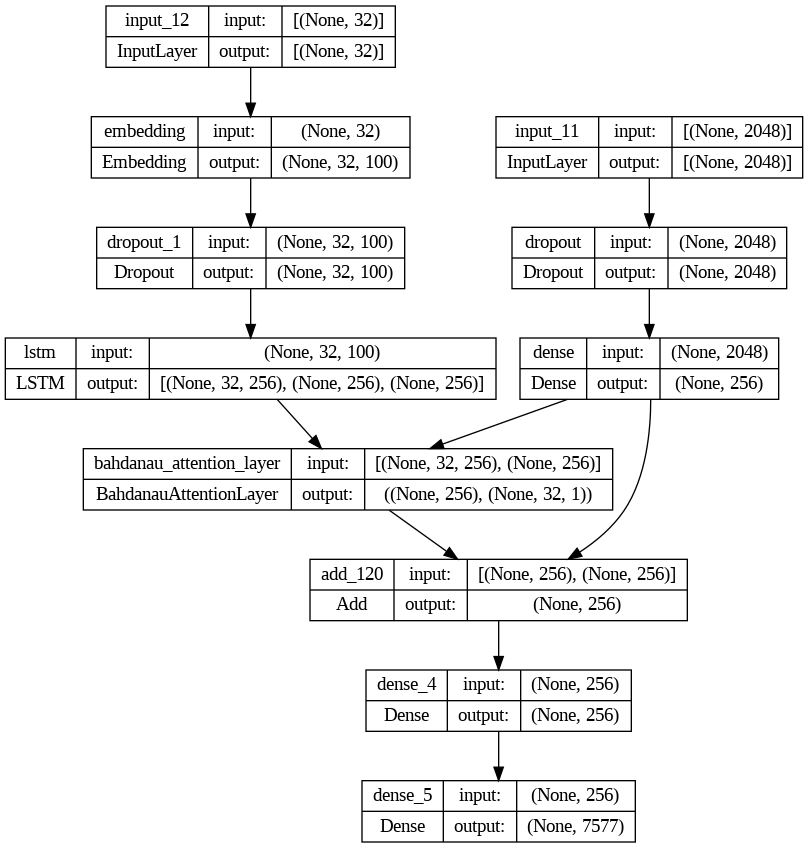

In [ ]:
model = load_model("glove_attention_9.h5")
plot_model(model, to_file='model.png', show_shapes=True)

In [ ]:
model = load_model("glove_attention_9.h5",custom_objects={'BahdanauAttentionLayer': BahdanauAttentionLayer})